<a href="https://colab.research.google.com/github/nitin649/FacialKeypointsDetection/blob/main/Facial_keypoints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
#data augumentation
!pip install albumentations==0.4.6
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

     |████████████████████████████████| 117 kB 4.2 MB/s 
     |████████████████████████████████| 948 kB 30.1 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65172 sha256=ef4d99e011487e075b87d06be59ce19617940fdbda4c51cea224c8f48e6b9988
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 5e-4
BATCH_SIZE = 64
NUM_EPOCHS = 100
NUM_WORKERS = 4
CHECKPOINT_PATH = "/content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel"
PIN_MEMORY = True
SAVE_MODEL = True
LOAD_MODEL = True

In [ ]:
# Data augmentation for images
train_transforms = A.Compose(
    [
        A.Resize(width=96, height=96),#image resizing 
        A.Rotate(limit=15, border_mode=cv2.BORDER_CONSTANT, p=0.8),#rotating of image with prob of 80 percent 
        A.IAAAffine(shear=15, scale=1.0, mode="constant", p=0.2),
        A.RandomBrightnessContrast(contrast_limit=0.5, brightness_limit=0.5, p=0.2),
        A.OneOf([#randomly select one of these and will apply on data 
            A.GaussNoise(p=0.8),
            A.CLAHE(p=0.8),
            A.ImageCompression(p=0.8),
            A.RandomGamma(p=0.8),
            A.Posterize(p=0.8),
            A.Blur(p=0.8),
        ], p=1.0),
        A.OneOf([
            A.GaussNoise(p=0.8),
            A.CLAHE(p=0.8),
            A.ImageCompression(p=0.8),
            A.RandomGamma(p=0.8),
            A.Posterize(p=0.8),
            A.Blur(p=0.8),
        ], p=1.0),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0, p=0.2, border_mode=cv2.BORDER_CONSTANT),
        A.Normalize(
            mean=[0.4897, 0.4897, 0.4897],#here we are taking mean thrice because the data we have is in grayscale and EfficientNetB0 model takes
            #input in 3 channel form
            std=[0.2330, 0.2330, 0.2330],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ], keypoint_params=A.KeypointParams(format="xy", remove_invisible=False),
)


val_transforms = A.Compose( #transformation for validation
    [
        A.Resize(height=96, width=96),
        A.Normalize(
            mean=[0.4897, 0.4897, 0.4897],
            std=[0.2330, 0.2330, 0.2330],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ], keypoint_params=A.KeypointParams(format="xy", remove_invisible=False),
)

In [ ]:
import pandas as pd
import numpy as np
import cv2
from PIL import Image

In [ ]:
train_data=pd.read_csv(r"/content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/training.csv")
test_data=pd.read_csv(r"/content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/test.csv")

In [ ]:
#image 
image=train_data['Image'][0]
image = np.array(image.split()).astype(np.uint8)
image = image.reshape(96, 96)
img = Image.fromarray(image, 'L')

In [ ]:
img.size

(96, 96)

In [ ]:
#dataset creation
from torch.utils.data import DataLoader,Dataset

In [ ]:
class facialDataset(Dataset):
  def __init__(self,csv_file,train=True,transform=None):
    super().__init__()
    self.data=pd.read_csv(csv_file)
    self.category_names = ['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y', 'left_eye_inner_corner_x', 'left_eye_inner_corner_y', 'left_eye_outer_corner_x', 'left_eye_outer_corner_y', 'right_eye_inner_corner_x', 'right_eye_inner_corner_y', 'right_eye_outer_corner_x', 'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y', 'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x', 'mouth_right_corner_y', 'mouth_center_top_lip_x', 'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y']
    self.transform = transform
    self.train = train

  def __len__(self,):
    return self.data.shape[0]
  def __getitem__(self,index):
    #data for training
    if self.train:#this is for training
      image=np.array(self.data.iloc[index,30].split()).astype(np.float32) #image 
      labels=np.array(self.data.iloc[index,:30].tolist())#labels ex left_eye_center_x ,----------------
      labels[np.isnan(labels)]=-1 #inserting NAN val to -1
    else:
      #print('inside else')
      image = np.array(self.data.iloc[index, 1].split()).astype(np.float32)
      #print(image,'inside else',index)
      labels = np.zeros(30)#inserting 0 in 30 labels 
    ignore_indices = labels == -1#give true or flase , as we know that we have inserted -1 in the place of NAN we should ignore those labels during training 
    labels = labels.reshape(15, 2)#converting into (15,2) here 2-->is for x,y because we have the data in x and y format "left_eye_center_x-->x" "left_eye_center_y-->y"
    
    if self.transform:
            image = np.repeat(image.reshape(96, 96, 1), 3, 2).astype(np.uint8)#here we are repeating our channel into 3 as our model will take input in this way only
            augmentations = self.transform(image=image, keypoints=labels)
            image = augmentations["image"]
            labels = augmentations["keypoints"]
    labels = np.array(labels).reshape(-1)#flatting the labels into [1,30]
    labels[ignore_indices] = -1

    return image, labels.astype(np.float32)
 


x torch.Size([1, 3, 96, 96]) y torch.Size([1, 30])


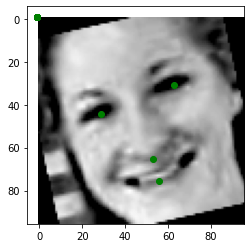

In [ ]:
import matplotlib.pyplot as plt
if __name__ == "__main__":
    ds = facialDataset(csv_file=r"/content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/training.csv", train=True, transform=train_transforms)
    print(ds)
    loader = DataLoader(ds, batch_size=1, shuffle=True, num_workers=0)
    for idx, (x, y) in enumerate(loader):
      print('x',x.shape,'y',y.shape)#x torch.Size([1-->batch, 3-->channel, 96, 96]) y torch.Size([1, 30-->labels])
      plt.imshow(x[0][0].detach().cpu().numpy(), cmap='gray')
      plt.plot(y[0][0::2].detach().cpu().numpy(), y[0][1::2].detach().cpu().numpy(), "go")#[0::2] slice the list from 0 with step of 2 because we have the data in this format
      #x_feature_1,y_feature_1,x_feature_2,y_feature_2,-----------------------------
      plt.show()
      break
      


    #this is how output will look if we have 4 keypoints instead of 15 at the place of NAN we have -1 
    # x torch.Size([1, 3, 96, 96]) y torch.Size([1, 30])
    # tensor([72.4140, 38.5874, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
    #     -1.0000, -1.0000, 50.5448, -1.0000, -1.0000, -1.0000, 49.4860]) 

In [ ]:
#model creation
!pip install efficientnet_pytorch
from torch import nn,optim
from tqdm import tqdm
from efficientnet_pytorch import EfficientNet

In [ ]:
def train_for_epoch(loader,model,optimizer,loss_fn,scaler,device):
  losses=[]
  loop=tqdm(loader)
  num_examples=0
  for batch_idx,(data,targets) in enumerate(loop):
    data=data.to(device=device)
    targets=targets.to(device=device)

    #forward pass
    scores=model(data)
    scores[targets==-1]=-1#target is qual to -1 set scores also to -1
    loss=loss_fn(scores,targets)
    num_examples+=torch.numel(scores[targets!=-1])#for calculating exact loss we have to consider only original 1 not -1 which we placed in the place of NAN
    losses.append(loss.item())

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f"Loss average over epoch: {(sum(losses)/num_examples)**0.5}")



In [ ]:
def save_checkpoint(state, filename=None):
    checkpoint_path=CHECKPOINT_PATH
    filename=os.path.join(checkpoint_path,filename)
    print("=> Saving checkpoint",filename)
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer, lr):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [ ]:
#creating 2 models , one for 15 keypoints and one is for 4 keypoints
CHECKPOINT_FILE="my_checkpoint_B0.pth.tar"
import os
def main():
  train_ds = facialDataset(
        csv_file="/content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/training.csv",
        transform=train_transforms,
    )
  train_loader = DataLoader(
      train_ds,
      batch_size=BATCH_SIZE,
      num_workers=NUM_WORKERS,
      pin_memory=PIN_MEMORY,
      shuffle=True,
  )
  # val_ds = facialDataset(
  #     transform=val_transforms,
  #     csv_file="data/val_4.csv",
  # )
  # val_loader = DataLoader(
  #     val_ds,
  #     batch_size=BATCH_SIZE,
  #     num_workers=NUM_WORKERS,
  #     pin_memory=PIN_MEMORY,
  #     shuffle=False,
  # )

  # test_ds = facialDataset(
  #     csv_file="data/test.csv",
  #     transform=val_transforms,
  #     train=False,
  # )

  # test_loader = DataLoader(
  #     test_ds,
  #     batch_size=1,
  #     num_workers=NUM_WORKERS,
  #     pin_memory=PIN_MEMORY,
  #     shuffle=False,
  # )

  loss_fn = nn.MSELoss(reduction="sum")#here we are using sum not average because we have to neglect the -1 values as we it is not calculated in the loss 
  #single model architecture
  model = EfficientNet.from_pretrained("efficientnet-b0")
  model._fc = nn.Linear(1280, 30)#output of efficientnet is of size of 1280 and 30 is the total labels
  model = model.to(DEVICE)
  optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
  scaler = torch.cuda.amp.GradScaler()

  #2 model architecture 
  model_4 = EfficientNet.from_pretrained("efficientnet-b0")
  model_4._fc = nn.Linear(1280, 30)
  model_15 = EfficientNet.from_pretrained("efficientnet-b0")
  model_15._fc = nn.Linear(1280, 30)
  model_4 = model_4.to(DEVICE)
  model_15 = model_15.to(DEVICE)

  if LOAD_MODEL and CHECKPOINT_FILE in os.listdir(r"/content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel"):
      load_checkpoint(torch.load(CHECKPOINT_FILE), model, optimizer, LEARNING_RATE)
      #load_checkpoint(torch.load("b0_4.pth.tar"), model_4, optimizer, LEARNING_RATE)
      #load_checkpoint(torch.load("b0_15.pth.tar"), model_15, optimizer, LEARNING_RATE)

  #get_submission(test_loader, test_ds, model_15, model_4)

  for epoch in range(NUM_EPOCHS):
      #get_rmse(val_loader, model, loss_fn, DEVICE)
      train_for_epoch(train_loader, model, optimizer, loss_fn, scaler,DEVICE)

      # get on validation
      if SAVE_MODEL:
          checkpoint = {
              "state_dict": model.state_dict(),
              "optimizer": optimizer.state_dict(),
          }
          save_checkpoint(checkpoint, filename=CHECKPOINT_FILE)

In [ ]:
if __name__=="__main__":
  main()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Loss average over epoch: 50.23811693679932
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.75it/s]


Loss average over epoch: 42.940383482844624
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.75it/s]


Loss average over epoch: 38.45925059932506
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.74it/s]


Loss average over epoch: 34.239427208734504
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.76it/s]


Loss average over epoch: 31.4103813274733
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:02<00:00,  1.78it/s]


Loss average over epoch: 27.73318671120903
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:02<00:00,  1.79it/s]


Loss average over epoch: 20.391544335783532
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:02<00:00,  1.77it/s]


Loss average over epoch: 15.548388138066741
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.75it/s]


Loss average over epoch: 12.398937850096345
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.74it/s]


Loss average over epoch: 10.172324005834133
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.76it/s]


Loss average over epoch: 8.449201564427064
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.75it/s]


Loss average over epoch: 7.378880112879581
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.75it/s]


Loss average over epoch: 6.6098195218419935
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:02<00:00,  1.79it/s]


Loss average over epoch: 6.027996980673336
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:02<00:00,  1.76it/s]


Loss average over epoch: 5.708644709056222
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Loss average over epoch: 5.4821623349930295
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:02<00:00,  1.76it/s]


Loss average over epoch: 5.299007744118045
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Loss average over epoch: 5.258362395480876
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Loss average over epoch: 5.154415355768143
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Loss average over epoch: 5.106318199609474
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.74it/s]


Loss average over epoch: 5.065709069527924
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Loss average over epoch: 5.026802118086295
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:04<00:00,  1.71it/s]


Loss average over epoch: 4.9916700112372405
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.74it/s]


Loss average over epoch: 4.9970801529855216
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:02<00:00,  1.77it/s]


Loss average over epoch: 4.970807343752471
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.75it/s]


Loss average over epoch: 4.94929704453358
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.76it/s]


Loss average over epoch: 4.91443148679254
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:02<00:00,  1.76it/s]


Loss average over epoch: 4.887861303512475
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.76it/s]


Loss average over epoch: 4.852003889372162
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.75it/s]


Loss average over epoch: 4.776323000811221
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Loss average over epoch: 4.822468675836614
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Loss average over epoch: 4.741734579691963
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.74it/s]


Loss average over epoch: 4.72831448560262
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.75it/s]


Loss average over epoch: 4.594516843550412
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.75it/s]


Loss average over epoch: 4.570676216717406
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.76it/s]


Loss average over epoch: 4.461475395829918
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.75it/s]


Loss average over epoch: 4.370734804409021
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Loss average over epoch: 4.276034939894167
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.74it/s]


Loss average over epoch: 4.151996486978744
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.76it/s]


Loss average over epoch: 4.0692491832529925
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.74it/s]


Loss average over epoch: 4.026640100214699
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.75it/s]


Loss average over epoch: 3.942660592657481
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Loss average over epoch: 3.904511203359259
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Loss average over epoch: 3.882067047732987
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.74it/s]


Loss average over epoch: 3.744655356277875
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Loss average over epoch: 3.659596086223454
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.74it/s]


Loss average over epoch: 3.5606373247536447
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:02<00:00,  1.77it/s]


Loss average over epoch: 3.3716234071099906
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.76it/s]


Loss average over epoch: 3.32558821186362
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.74it/s]


Loss average over epoch: 3.251345723759361
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.74it/s]


Loss average over epoch: 3.1606259462154487
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.74it/s]


Loss average over epoch: 3.1445607571929055
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:02<00:00,  1.77it/s]


Loss average over epoch: 3.060985321615455
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.74it/s]


Loss average over epoch: 2.995563646739253
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:02<00:00,  1.77it/s]


Loss average over epoch: 2.945372195153025
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.74it/s]


Loss average over epoch: 2.89318272016056
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Loss average over epoch: 2.878883514426875
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Loss average over epoch: 2.8561007003471888
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.73it/s]


Loss average over epoch: 2.79269499165323
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.74it/s]


Loss average over epoch: 2.7769404764717853
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Loss average over epoch: 2.7842113929094747
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.74it/s]


Loss average over epoch: 2.728745376214618
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.74it/s]


Loss average over epoch: 2.6893521690034836
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.76it/s]


Loss average over epoch: 2.6807077263201453
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.74it/s]


Loss average over epoch: 2.669961366159854
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Loss average over epoch: 2.6741771728716905
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:04<00:00,  1.71it/s]


Loss average over epoch: 2.6043277898846675
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.74it/s]


Loss average over epoch: 2.6119675294797124
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.74it/s]


Loss average over epoch: 2.6130736078502337
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.75it/s]


Loss average over epoch: 2.556836050046358
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Loss average over epoch: 2.552450266941861
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Loss average over epoch: 2.50519895693916
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.75it/s]


Loss average over epoch: 2.5108127599732883
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Loss average over epoch: 2.509570939994527
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.74it/s]


Loss average over epoch: 2.4852470883603637
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:02<00:00,  1.77it/s]


Loss average over epoch: 2.4758928284998194
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.75it/s]


Loss average over epoch: 2.4782770138500534
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.76it/s]


Loss average over epoch: 2.4279346929334364
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.74it/s]


Loss average over epoch: 2.439815232928488
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.75it/s]


Loss average over epoch: 2.4148352089713003
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.74it/s]


Loss average over epoch: 2.4072492064439683
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:02<00:00,  1.77it/s]


Loss average over epoch: 2.4002101905111624
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:01<00:00,  1.80it/s]


Loss average over epoch: 2.400097928309294
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:02<00:00,  1.78it/s]


Loss average over epoch: 2.374475112747948
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:01<00:00,  1.79it/s]


Loss average over epoch: 2.3534374385272483
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:02<00:00,  1.79it/s]


Loss average over epoch: 2.371757486415702
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:01<00:00,  1.79it/s]


Loss average over epoch: 2.3436636100686434
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:02<00:00,  1.78it/s]


Loss average over epoch: 2.3266641930330225
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Loss average over epoch: 2.3046883491165007
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Loss average over epoch: 2.277614490748972
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.75it/s]


Loss average over epoch: 2.2818406170199177
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Loss average over epoch: 2.2758773053686716
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Loss average over epoch: 2.326881139004911
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:04<00:00,  1.71it/s]


Loss average over epoch: 2.2712113587380287
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:05<00:00,  1.71it/s]


Loss average over epoch: 2.285096528744637
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Loss average over epoch: 2.211538793031729
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:05<00:00,  1.71it/s]


Loss average over epoch: 2.2448059243077534
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:05<00:00,  1.68it/s]


Loss average over epoch: 2.2136588218757733
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Loss average over epoch: 2.233321815351684
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


100%|██████████| 111/111 [01:03<00:00,  1.73it/s]


Loss average over epoch: 2.2627817882467527
=> Saving checkpoint /content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar


In [ ]:
for idx, (x, y) in enumerate(loader):
      print('x',x.shape,'y',y.shape)#x torch.Size([1-->batch, 3-->channel, 96, 96]) y torch.Size([1, 30-->labels])
      print(y[0][0::2])
      break
    #     plt.imshow(x[0][0].detach().cpu().numpy(), cmap='gray')
    #     plt.plot(y[0][0::2].detach().cpu().numpy(), y[0][1::2].detach().cpu().numpy(), "go")
    #     plt.show()

In [ ]:
#testing
test_ds = facialDataset(
        csv_file="/content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/test.csv",
        train=False,
        transform=val_transforms,
    )
test_loader = DataLoader(
    test_ds,
    batch_size=1,#just for checking
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
model = EfficientNet.from_pretrained("efficientnet-b0")
model._fc = nn.Linear(1280, 30)#output of efficientnet is of size of 1280 and 30 is the total labels
model = model.to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scaler = torch.cuda.amp.GradScaler()
checkpoint=torch.load(r"/content/gdrive/MyDrive/Colab Notebooks/LanguageTranslationModel/my_checkpoint_B0.pth.tar")
model.load_state_dict(checkpoint["state_dict"])
model.eval()

Loaded pretrained weights for efficientnet-b0


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


inside else
inside else
inside else
inside else
[ 1.  3.  6. ... 22. 33. 28.] inside else 1366
[215. 208. 199. ...  82.  77.  82.] inside else 836
[38. 37. 35. ... 10. 10. 10.] inside else 1638
[30. 30. 30. ... 69. 70. 70.] inside else 1015
inside else
inside else
[ 59.  64.  63. ... 248. 255. 255.] inside else 388
inside else
[51. 53. 55. ... 94. 96. 94.] inside else 674
inside else
[177. 176. 174. ...   1.   1.   1.] inside else 2
inside else
[  6.   0.   1. ...  85. 139. 145.] inside else 179
[ 30.  30.  29. ... 135. 137. 140.] inside else 1526
0
tensor([[67.4014, 37.5628, 31.1602, 42.6257, 59.1929, 39.3470, 74.1384, 37.2923,
         38.2395, 41.9316, 24.2498, 43.2915, 54.5233, 31.7410, 78.5129, 28.4437,
         37.6036, 34.4913, 18.0672, 36.1993, 48.8935, 65.8330, 69.5537, 73.1045,
         37.4441, 76.3693, 51.7964, 74.8662, 52.5344, 78.6992]],
       device='cuda:0', grad_fn=<AddmmBackward>) torch.Size([1, 30]) tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

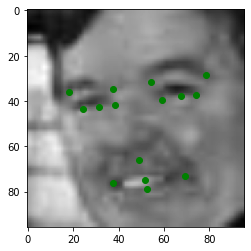

In [ ]:
#evaluating on some samples
count=0
for idx, (data,labels) in enumerate(test_loader):
  #print(data,labels)]
  print(idx)
  data=data.to(device=DEVICE)
  score=model(data)#calculating the score means labels
  print(score,score.shape,labels)
  plt.imshow(data[0][0].detach().cpu().numpy(), cmap='gray')
  plt.plot(score[0][0::2].detach().cpu().numpy(), score[0][1::2].detach().cpu().numpy(), "go")
  break


In [ ]:
for idx, (data,labels) in enumerate(test_loader):
  #print(data,labels)]
  print(data.shape)
  break


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


inside else
inside else
inside else
inside else
[ 79.  72.  65. ... 169. 166. 179.] inside else 777
[11.  5. 17. ... 31. 38. 47.] inside else 581
[159. 158. 154. ...  44.  45.  47.] inside else 79
inside else
inside else
inside else
[231. 236. 160. ...  20.  19.  19.] inside else 1530
[150. 151. 145. ...  84.  94. 105.] inside else 256
[149. 147. 150. ... 199. 207. 210.] inside else 1600
[254. 254. 254. ...  43.  69.  97.] inside else 100
torch.Size([1, 3, 96, 96])
